# CNN

colab에서 열기: https://colab.research.google.com/github/SLCFLAB/Fintech2022/blob/main/ML_day10_2.ipynb

- 선형신경망의 경우, pixel을 펴서 학습시키기 때문에 공간적 구조를 잃어버릴 수 있음. 
- 또한, 저장되어야 하는 parameter가 매우 많음.
- 이미지 처리를 위해 CNN 모델이 만들어짐.
- 필터의 연산 활용함.


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision.utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import numpy as np
import random
import os

import matplotlib.pyplot as plt
%matplotlib inline

## Load data

In [3]:
train_data = dsets.MNIST(root='data/',
                         train=True,
                         transform=transforms.ToTensor(),
                         download=True)

test_data = dsets.MNIST(root='data/',
                        train=False,
                        transform=transforms.ToTensor(),
                        download=True)

/home/tako/anaconda3/envs/torch/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448265233/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
batch_size = 100 # 한번에 할 연산량

train_loader = DataLoader(dataset=train_data,
                          batch_size=batch_size,
                          shuffle=True)

test_loader = DataLoader(dataset=test_data,
                         batch_size=batch_size,
                         shuffle=False)

In [5]:
def imshow(img, title):
    img = torchvision.utils.make_grid(img, normalize=True)images, labels = iter(train_loader).next()
imshow(images, "Train Image")
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.axis('off')
    plt.show()

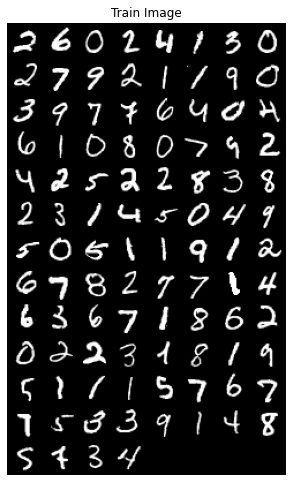

In [6]:
images, labels = iter(train_loader).next()
imshow(images, "Train Image")

In [7]:
images.shape, labels[0:5] # batch, filter, size 
#MNIST는 흑백 이미지기 때문에 filter = 1, 
#CIFAR10 등은 컬러 이미지라 filter = 3

(torch.Size([100, 1, 28, 28]), tensor([2, 6, 0, 2, 4]))

## Define model

- CNN 모델은 일반적으로 covolution과 pooling layer로 구성되어 있음(보통 그 사이에 ReLU layer을 넣지만, 최근 연구결과 순서를 바꿔도 됨이 밝혀짐)
- filter을 이용해 연산을 하면 크기가 줄어듦, padding을 통해 이를 해결할 수 있음.
- pooling을 통해 중요한 정보만 남게 할 수 있음. 보통 max pooling을 사용하며, 예를들어 2*2 max pooling을 하면 크기는 반으로 줄어듦.
- stride를 통해 건너뛰면서 연산을 할 수도 있음.


모델 만들 때 크기 계산 필수적임!!!
- input : N * N
- padding : P
- stride : S
- Filter : F * F

### output = {[(N+2P-F)/S] + 1} * {[(N+2P-F)/S] + 1} 
여기서 []는 가우스기호

In [9]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv_layer = nn.Sequential(
            nn.Conv2d(1, 16, 5), #[100,16,24,24]
            nn.ReLU(),
            nn.Conv2d(16, 32, 5),#[100,32,20,20]
            nn.ReLU(),
            nn.MaxPool2d(2, 2),#100,32,10,10
            nn.Conv2d(32, 64, 5),#100,64,6,6
            nn.ReLU(),
            nn.MaxPool2d(2, 2)#100,64,3,3 -> 여기서 batch 빼고 나머지 64*3*3
        )
        
        self.fc_layer = nn.Sequential(
            nn.Linear(64*3*3, 100), #여기서 64*3*3 -> 100
            nn.ReLU(),
            nn.Linear(100, 10)#100 -> 10
        )       
        
    def forward(self,x):
        out = self.conv_layer(x)
        out = out.view(-1,64*3*3)
        out = self.fc_layer(out)

        return out

In [10]:
model = CNN().cuda() ## GPU 사용

In [11]:
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

## Train model

In [14]:
num_epochs = 3

In [15]:
for epoch in range(num_epochs):

    total_batch = len(train_data) // batch_size

    for i, (batch_images, batch_labels) in enumerate(train_loader):

        X = batch_images.cuda()
        Y = batch_labels.cuda()

        pre = model(X)
        cost = loss(pre, Y)

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        if (i+1) % 300 == 0:
            print('Epoch [%d/%d], lter [%d/%d], Loss: %.4f'
                 %(epoch+1, num_epochs, i+1, total_batch, cost.item()))

/home/tako/anaconda3/envs/torch/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448265233/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch [1/3], lter [300/600], Loss: 2.2712
Epoch [1/3], lter [600/600], Loss: 0.4670
Epoch [2/3], lter [300/600], Loss: 0.3991
Epoch [2/3], lter [600/600], Loss: 0.1798
Epoch [3/3], lter [300/600], Loss: 0.1469
Epoch [3/3], lter [600/600], Loss: 0.1803


## Test model

In [16]:
correct = 0
total = 0

for images, labels in test_loader:
    
    images = images.cuda()
    outputs = model(images)
    
    _, predicted = torch.max(outputs.data, 1)
    
    total += labels.size(0)
    correct += (predicted == labels.cuda()).sum()
    
print('Accuracy of test images: %f %%' % (100 * float(correct) / total))

Accuracy of test images: 95.700000 %
